## **AI Agent - using Licensed Tripadvisor**

**This guide shows you how to build and deploy a tailored AI agent using Azure AI Projects that integrates with TripAdvisor's licensed Content API via OpenAPI.**
The agent is designed to access extensive, real-time information including hotel listings, restaurant reviews, attractions, photos, and additional data to provide personalized and insightful travel assistance.


Highlighted Features:

**Trusted Data Source:** Utilizes Azure AI Projects to develop an intelligent agent

that is backed by TripAdvisor’s reputable data.

**API Integration:** Connects with the TripAdvisor Content API using an OpenAPI specification, ensuring secure management of API keys.

**Flexible Authentication: **Supports custom key-based authentication through Azure AI Foundry or a code-first approach.

**Dynamic Data Retrieval:** Enables the agent to fetch and summarize real-time, location-based insights such as reviews, photos, and recommendations.

**Conversational Assistance:** Powers a travel assistant capable of offering personalized, current travel planning advice.



**Tutorial Objectives:**

Securely manage and connect your TripAdvisor API key using Azure AI Projects.

Leverage the OpenAPI specification to integrate TripAdvisor functionalities into your agent.

Configure the agent to interact with and use TripAdvisor’s data dynamically in real time.
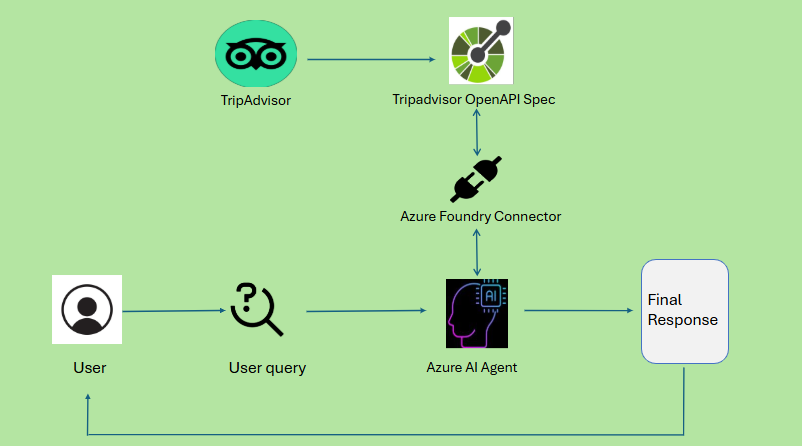

**How to  get a TripAdvisor content api key?**

visit: https://www.tripadvisor.com/developers

Click on "Login to get Started"

upon logging in, you would be taken to a checkout page, fill the billing information and click on confirm order.

Follow instructions and you can get your api key.
(Note: you can choose the billing amount according to your use case)

**Setup**

Go to Azure AI Foundry portal and select your AI Project. Select Management Center.


Select +new connection in the settings page.


Select custom keys in other resource types.


Enter the following information to create a connection to store your Tripadvisor key:

Set Custom keys to key, with the value being your Tripadvisor API key.
Make sure is secret is checked.

Set the connection name to your connection name. You use this connection name in your sample code or Foundry Portal later.

For the Access setting, you can choose either this project only or shared to all projects. Just make sure in your code, the connection string of the project you entered has access to this connection.


**Agent Creation in Azure AI Foundry**

**Step 1: **Navigate to Agents
In your AI Foundry project:
Look for "Agents" in the left navigation menu
Click on "Agents"

**Step 2:** Create New Agent
Click "Create agent" or "+ New agent"

Configure Agent Basic Settings:

Agent name: TripAdvisor Assistant
Description: Travel planning and recommendation assistant

Choose AI Model:

Select a model (e.g., GPT-4, GPT-3.5-turbo)
Choose version based on your needs and budget

**Step 3**: Configure Agent Instructions
System Instructions (Prompt):

You are a helpful travel assistant specializing in TripAdvisor-style recommendations.
You help users plan trips, find accommodations, restaurants, and attractions.
Provide detailed, helpful, and engaging travel advice.

**Step 4**: To integrate TripAdvisor API, beneath agent Description, you can find another option named knowledge. Click on "+ Add" next to knowledge.

Within the nw popup box you can see Tripadvisor in the window, click on it.

Give a name and a description on what it is like " Travel assisatnt that returns details about user queries."

In the next step; define schema a schema would be already generated thee for you.

Click on next step and finish setting up the project.

And your data source is ready to retrieve knowledge from tripadvisor. **bold text**


Additional Settings:

Temperature: 0.7 (for balanced creativity)
Max tokens: 1000
Top P: 0.9

**Step 5**: Test and Deploy Agent
Test the Agent:

Use the built-in chat interface to test
Send a test message: "Hello, I need help planning a trip"
Deploy the Agent:

Click "Deploy" or "Save and Deploy"



In [2]:
#!pip install jsonref==1.1.0

In [1]:
# Installs the Azure AI Projects SDK and Azure Identity library for authentication
#!pip install azure-ai-projects==1.0.0b11 azure-identity==1.3.1 load_dotenv

In [4]:
from azure.identity import ClientSecretCredential
from azure.ai.projects import AIProjectClient
from azure.ai.agents.models import ListSortOrder
from azure.ai.agents.models import (
    OpenApiTool,
    OpenApiConnectionAuthDetails,
    OpenApiConnectionSecurityScheme
)
import jsonref
import asyncio
from pathlib import Path

# Azure AI Project Configuration
import os
from dotenv import load_dotenv
load_dotenv('agents.env')
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
TENANT_ID = os.getenv("TENANT_ID")
PROJECT_ENDPOINT = os.getenv("PROJECT_ENDPOINT")

# Connection configuration
OPENAPI_SCHEMA_FILE = "../data/tripadvisor_api_schema.json"
connection_name= "tripadvisor-connection" #Enter your CONNECTED RESOURCE name here

#Initializing connection to Azure using client credentials.
def _initialize_azure_client():
    """Initialize Azure AI Project client"""
    credential = ClientSecretCredential(
        tenant_id=TENANT_ID,
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET
    )

    project_client = AIProjectClient(
        credential=credential,
        endpoint=PROJECT_ENDPOINT
    )
    return project_client

#Loads OpenAPI Schema
def load_openapi_schema():
    """Load OpenAPI schema from JSON file"""
    with open(OPENAPI_SCHEMA_FILE, 'r', encoding='utf-8') as f:
        return jsonref.loads(f.read())

#Creates a tool that the AI agent can use to call the TripAdvisor API
def create_openapi_tool(connection_id: str):
    """Create OpenAPI tool with connected resource authentication"""
    openapi_spec = load_openapi_schema()

    auth = OpenApiConnectionAuthDetails(
        security_scheme=OpenApiConnectionSecurityScheme(
            connection_id=connection_id
        )
    )

    api_title = openapi_spec.get('info', {}).get('title', 'TripAdvisor API')

    return OpenApiTool(
        name="tripadvisor_api",
        spec=openapi_spec,
        description=f"{api_title} for travel content and recommendations",
        auth=auth
    )


#Creates the actual AI agent with TripAdvisor capabilities
def create_travel_agent(project_client):
    """Create Azure AI Agent with TripAdvisor OpenAPI tool"""
    conn_list = project_client.connections.list()
    connection_id = [conn["id"] for conn in conn_list if conn.get("name") == connection_name][0]
    openapi_tool = create_openapi_tool(connection_id)

    instructions = """You are a travel assistant with direct access to the TripAdvisor API.
        Use the tripadvisor_api tool to search for locations, hotels, restaurants, and attractions.
        Get detailed information including ratings, reviews, and descriptions.
        Provide real-time travel recommendations with specific details like ratings, addresses, and contact info."""

    agent = project_client.agents.create_agent(
        model=os.environ["MODEL_DEPLOYMENT_NAME"],
        name="TripAdvisor-API-Assistant",
        description="Travel assistant with TripAdvisor API access",
        instructions=instructions,
        temperature=0.7,
        tools=openapi_tool.definitions
    )

    return agent


#Creates a conversation thread to maintain chat history
def create_conversation_thread():
    """Create conversation thread"""
    thread = project_client.agents.threads.create()
    return thread

#Handles the core conversation logic
def process_conversation(user_message: str) -> str:
    """Process user message and return response"""
    project_client.agents.messages.create(
        thread_id=thread.id,
        role="user",
        content=user_message
    )

    run = project_client.agents.runs.create_and_process(
        thread_id=thread.id,
        agent_id=agent.id
    )

    if run.status == "completed":
        messages = project_client.agents.messages.list(
            thread_id=thread.id,
            order=ListSortOrder.DESCENDING,
            limit=1
        )

        latest_message = next(msg for msg in messages if msg.role == "assistant")
        if agent_response := next((content.text.value for content in latest_message.content if content.type == "text"), None):
            return print(f"Agent: {agent_response}")

        #for message in messages:
        #    if message.role == "assistant" and hasattr(message, 'text_messages') and message.text_messages:
        #        return message.text_messages[-1].text.value

    return "Please try again."

#Cleans up resources when the program ends
def cleanup():
    """Clean up resources"""
    if thread:
        project_client.agents.threads.delete(thread.id)


"""Main execution"""
project_client=_initialize_azure_client()
agent=create_travel_agent(project_client)
thread=create_conversation_thread()

print("TripAdvisor Assistant Ready!")
print("Type 'exit' to quit.\n")

while True:
    user_input = input("You: ").strip()

    if user_input.lower() in ["exit", "quit"]:
        break

    if user_input:
        response = process_conversation(user_input)
        print(f"Assistant: {response}\n")

cleanup()


TripAdvisor Assistant Ready!
Type 'exit' to quit.



ServiceResponseError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))